In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

[0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

In [3]:
data_dir = "Cat_Dog_data"

In [4]:
ls example_dataset

 Volume in drive C has no label.
 Volume Serial Number is 3215-B96D

 Directory of C:\Users\fb\Desktop\StriveAI\Strive_AI_School_Part_2\M5_Deep_Learning\D8



File Not Found


In [5]:
import os

train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                    ])

In [6]:
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir,"test"), transform=test_transforms)

In [7]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data, batch_size=3, shuffle=True)
testloader = DataLoader(test_data, batch_size=3, shuffle=False)


<AxesSubplot:>

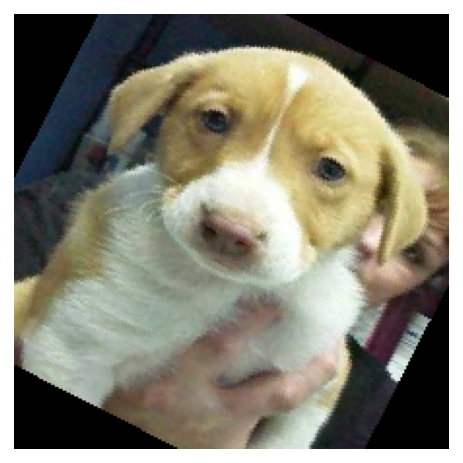

In [15]:
import numpy as np
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

images, labels = next(iter(trainloader))
imshow(images[0])

In [16]:
labels

tensor([1, 1, 0])

In [17]:
train_data.class_to_idx

{'cat': 0, 'dog': 1}

In [18]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
# not compute the gradients of the feature extractor
for param in model.parameters():
    param.requires_grad = False

In [20]:
from collections import OrderedDict

our_classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 10)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(10, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    

Replace the `model.classifier` with our `classifier`

In [21]:
model.classifier = our_classifier

In [23]:
model.features.conv0 

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [24]:
our_classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (output): LogSoftmax(dim=1)
)

In [25]:
for params in model.parameters():
    print(params.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003) # IMPORTANT

In [28]:
model.to(device);

In [29]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5
max_accuracy = 0
for epoch in range(epochs):
    for inputs, labels in trainloader:
        
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    if accuracy >= max_accuracy:
                        max_accuracy = accuracy
                        torch.save(model.state_dict(), 'checkpoint.pth')
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

KeyboardInterrupt: 

In [77]:
for x, y in trainloader:
    print(x.shape, y.shape)

torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([3, 3, 224, 224]) torch.Size([3])


In [79]:
x, y = next(iter(trainloader))

In [80]:
x.shape, y.shape

(torch.Size([3, 3, 224, 224]), torch.Size([3]))

In [113]:
trainiter = iter(trainloader)

In [107]:
dir(trainiter)

['_IterableDataset_len_called',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_base_seed',
 '_collate_fn',
 '_dataset',
 '_dataset_fetcher',
 '_dataset_kind',
 '_drop_last',
 '_index_sampler',
 '_next_data',
 '_next_index',
 '_num_workers',
 '_num_yielded',
 '_persistent_workers',
 '_pin_memory',
 '_prefetch_factor',
 '_reset',
 '_sampler_iter',
 '_timeout',
 'next']

In [110]:
images, label = next(trainiter)

In [112]:
trainiter._reset()

TypeError: _reset() missing 1 required positional argument: 'loader'

In [84]:
dir(trainloader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']